# metapath2vec: Scalable Representation Learning for Heterogeneous Networks


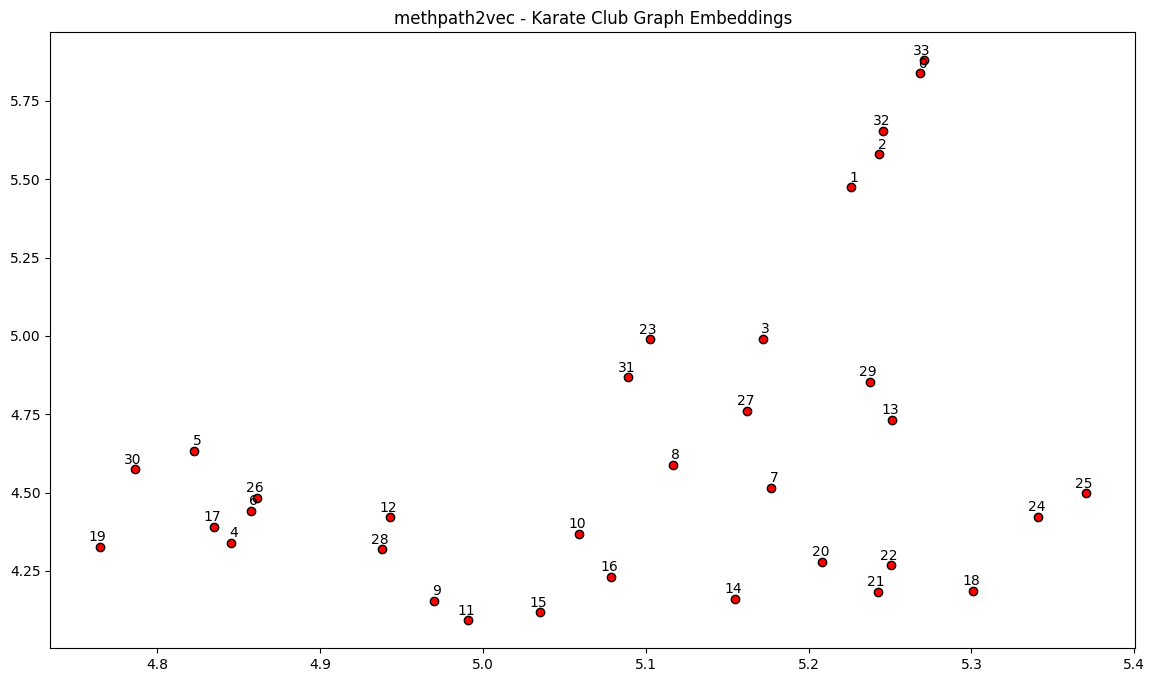

In [43]:
import numpy as np
import networkx as nx
import random
import threading
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class Word2Vec:
    def __init__(self, size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.min_count = min_count
        self.sg = sg
        self.iter = iter
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.index2word = []
        self.word2index = {}
        self.syn0 = None
        self.syn1neg = None
        self.table = None
        self.table_size = int(1e8)
    
    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1
        self.vocab = {word: freq for word, freq in self.vocab.items() if freq >= self.min_count}
        self.index2word = list(self.vocab.keys())
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}
    
    def init_net(self):
        vocab_size = len(self.vocab)
        self.syn0 = (np.random.rand(vocab_size, self.size) - 0.5) / self.size
        self.syn1neg = np.zeros((vocab_size, self.size))
        self.init_unigram_table()
    
    def init_unigram_table(self):
        power = 0.75
        norm = sum([self.vocab[word] ** power for word in self.vocab])
        self.table = []
        for word in self.vocab:
            p = (self.vocab[word] ** power) / norm
            self.table += [self.word2index[word]] * int(p * self.table_size)
        self.table = np.array(self.table)
    
    def train_model_thread(self, sentences, alpha, thread_id):
        random.seed(thread_id)
        for iteration in range(self.iter):
            for sentence in sentences:
                sentence = [word for word in sentence if word in self.vocab]
                for pos, word in enumerate(sentence):
                    current_word_idx = self.word2index[word]
                    context_start = max(0, pos - self.window)
                    context_end = min(len(sentence), pos + self.window + 1)
                    context = [self.word2index[sentence[i]] for i in range(context_start, context_end) if i != pos]
                    self.train_pair(current_word_idx, context, alpha)
    
    def train_pair(self, word_idx, context_idxs, alpha):
        for context_idx in context_idxs:
            self.update(word_idx, context_idx, alpha)
    
    def update(self, word_idx, context_idx, alpha):
        # Negative sampling
        neg_samples = np.random.choice(self.table, size=self.negative)
        labels = np.array([1] + [-1] * self.negative)
        target_idxs = np.array([context_idx] + list(neg_samples))
        
        l2 = self.syn1neg[target_idxs]
        prod_term = np.dot(self.syn0[word_idx], l2.T)
        sigmoid = 1 / (1 + np.exp(-prod_term * labels))
        g = (sigmoid - 1) * labels * alpha
        
        self.syn0[word_idx] -= np.dot(g, l2)
        self.syn1neg[target_idxs] -= np.outer(g, self.syn0[word_idx])
    
    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_net()
        alpha = self.alpha
        thread_data = []
        for thread_id in range(self.num_threads):
            start_idx = thread_id * len(sentences) // self.num_threads
            end_idx = (thread_id + 1) * len(sentences) // self.num_threads
            thread_data.append((sentences[start_idx:end_idx], alpha, thread_id))
        
        threads = [threading.Thread(target=self.train_model_thread, args=data) for data in thread_data]
        for t in threads:
            t.start()
        for t in threads:
            t.join()

def get_karate_club_sentences():
    G = nx.karate_club_graph()
    sentences = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            sentences.append([str(node), str(neighbor)])
    return sentences

# Example Usage
sentences = get_karate_club_sentences()
w2v = Word2Vec(size=100, window=5, negative=5, alpha=0.025, iter=5, num_threads=4)
w2v.train(sentences)

# Prepare data for t-SNE
word_vectors = w2v.syn0
word_labels = w2v.index2word

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the t-SNE results
plt.figure(figsize=(14, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], edgecolors='k', c='r')
for i, word in enumerate(word_labels):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.title("methpath2vec - Karate Club Graph Embeddings")
plt.show()


# Are Meta-Paths Necessary?: Revisiting Heterogeneous Graph Embeddings (JUST)

Generating walks ..
Walks done ..
Vocabulary size: 34
Filtered vocabulary size: 34


Training: 100%|██████████| 10/10 [00:00<00:00, 36.95it/s]


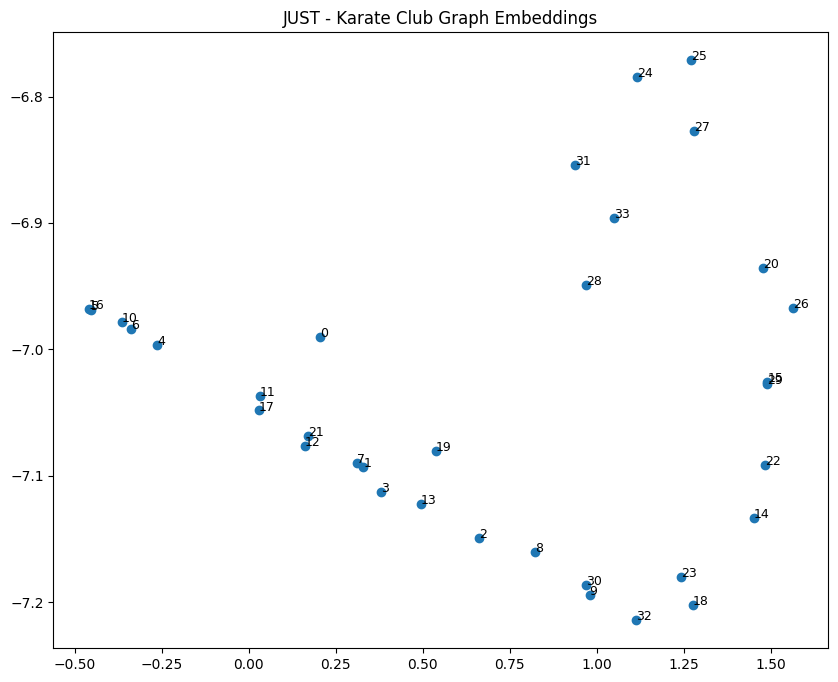

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE

class Word2Vec:
    def __init__(self, size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.min_count = min_count
        self.sg = sg
        self.iter = iter
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.index2word = []
        self.word2index = {}
        self.syn0 = None
        self.syn1neg = None
        self.table = None
        self.table_size = int(1e8)

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1

        self.index2word = [word for word, count in self.vocab.items() if count >= self.min_count]
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Filtered vocabulary size: {len(self.index2word)}")

    def init_weights(self):
        vocab_size = len(self.index2word)
        self.syn0 = np.random.uniform(-0.5 / self.size, 0.5 / self.size, (vocab_size, self.size))
        self.syn1neg = np.zeros((vocab_size, self.size))

    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_weights()

        for i in tqdm(range(self.iter), desc="Training"):
            self.train_epoch(sentences)

    def train_epoch(self, sentences):
        for sentence in sentences:
            for i, word in enumerate(sentence):
                if word not in self.word2index:
                    continue
                word_idx = self.word2index[word]
                start = max(0, i - self.window)
                end = min(len(sentence), i + self.window + 1)
                for j in range(start, end):
                    if j != i:
                        context_word = sentence[j]
                        if context_word in self.word2index:
                            context_idx = self.word2index[context_word]
                            self.train_pair(word_idx, context_idx)

    def train_pair(self, word_idx, context_idx):
        l1 = self.syn0[word_idx]
        l2 = self.syn1neg[context_idx]

        product = np.dot(l1, l2)
        g = self.alpha * (1 - product)

        self.syn0[word_idx] += g * l2
        self.syn1neg[context_idx] += g * l1

    def get_embeddings(self):
        return {word: self.syn0[idx] for word, idx in self.word2index.items()}

def dblp_generation(G, path_length, heterg_dictionary, alpha, start=None):
    path = [start]
    homog_length = 1
    no_next_types = False
    
    while len(path) < path_length and not no_next_types:
        cur = path[-1]
        homog_type = G.nodes[cur]['type']
        heterg_type = heterg_dictionary.get(homog_type, [])
        
        heterg_probability = 1 - math.pow(alpha, homog_length)
        r = random.uniform(0, 1)
        next_type_options = []

        if r <= heterg_probability:
            for ht in heterg_type:
                next_type_options.extend([e for e in G[cur] if G.nodes[e]['type'] == ht])
            if not next_type_options:
                next_type_options = [e for e in G[cur] if G.nodes[e]['type'] == homog_type]
        else:
            next_type_options = [e for e in G[cur] if G.nodes[e]['type'] == homog_type]
            if not next_type_options:
                for ht in heterg_type:
                    next_type_options.extend([e for e in G[cur] if G.nodes[e]['type'] == ht])
        
        if not next_type_options:
            no_next_types = True
        else:
            next_node = random.choice(next_type_options)
            path.append(next_node)
            if G.nodes[next_node]['type'] == G.nodes[cur]['type']:
                homog_length += 1
            else:
                homog_length = 1
    
    return path

def generate_walks(G, num_walks, walk_length, heterg_dictionary, alpha):
    print("Generating walks ..")
    walks = []
    nodes = list(G.nodes())
    
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = dblp_generation(G, walk_length, heterg_dictionary, alpha, start=node)
            walks.append(walk)
    print("Walks done ..")
    return walks

def generate_node_types(node_types_file):
    heterg_dictionary = {}
    with open(node_types_file) as f:
        for line in f:
            node_type, hete_values = line.strip().split(":")
            heterg_dictionary[node_type] = hete_values.split(",")
    return heterg_dictionary

def visualize_walks(G, walks):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    
    # Draw the graph
    nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=500, edge_color='gray')

    # Draw the walks
    for walk in walks:
        walk_edges = [(walk[i], walk[i+1]) for i in range(len(walk)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=walk_edges, edge_color='red', width=2)

    plt.title("Random Walks on Karate Club Graph")
    plt.show()

def visualize_embeddings(embeddings):
    labels = list(embeddings.keys())
    X = np.array([embeddings[label] for label in labels])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

    for i, label in enumerate(labels):
        plt.annotate(label, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=9)
    
    plt.title("JUST - Karate Club Graph Embeddings")
    plt.show()

# Example Usage

G = nx.karate_club_graph()
for node in G.nodes():
    G.nodes[node]['type'] = random.choice(['A', 'B', 'C'])

# Create a sample node types file
node_types_file = "node_types.txt"
with open(node_types_file, "w") as f:
    f.write("A:B,C\nB:A,C\nC:A,B\n")

# Generate node types dictionary
heterg_dictionary = generate_node_types(node_types_file)

# Generate random walks
walks = generate_walks(G, num_walks=5, walk_length=10, heterg_dictionary=heterg_dictionary, alpha=0.5)

# Flatten walks for Word2Vec training
flattened_walks = [[str(node) for node in walk] for walk in walks]

# Train Word2Vec model
w2v_model = Word2Vec(size=128, window=5, iter=10)
w2v_model.train(flattened_walks)

# Get the embeddings
embeddings = w2v_model.get_embeddings()

# Visualize the embeddings using t-SNE
visualize_embeddings(embeddings)


# BHIN2vec: Balancing the Type of Relation in Heterogeneous Information Network


Epoch 1, Loss: 0.03362870224847335
Epoch 2, Loss: 2.2772037892473788e-05
Epoch 3, Loss: 1.5130241703927168e-06
Epoch 4, Loss: 1.0716309901681598e-07
Epoch 5, Loss: 5.935420053861305e-09
Epoch 6, Loss: 2.2539570210255988e-10
Epoch 7, Loss: 0.0
Epoch 8, Loss: 0.0
Epoch 9, Loss: 0.0
Epoch 10, Loss: 0.0


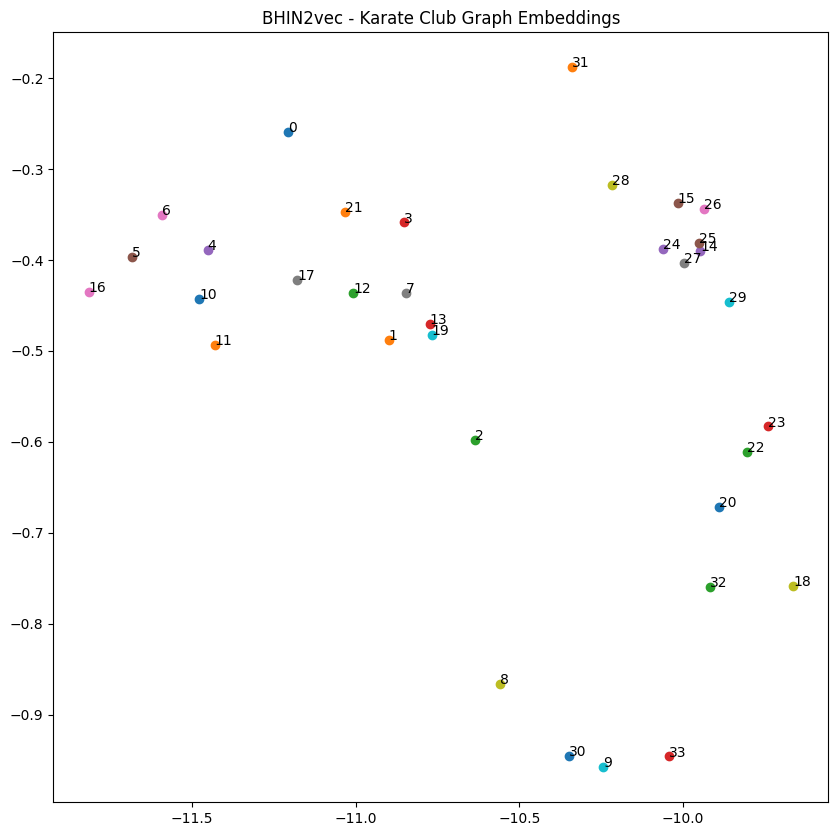

In [41]:
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

class SimpleSkipGramModel(nn.Module):
    def __init__(self, node_num, dim):
        super(SimpleSkipGramModel, self).__init__()
        self.node_embedding = nn.Embedding(node_num, dim)
        nn.init.normal_(self.node_embedding.weight.data, std=0.1)
    
    def forward(self, center_node, context_node):
        center_embed = self.node_embedding(center_node)
        context_embed = self.node_embedding(context_node)
        scores = torch.mul(center_embed, context_embed)
        return torch.sum(scores, dim=-1)
    
    def get_embeddings(self):
        return self.node_embedding.weight.data

def generate_walks(G, num_walks, walk_length):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                cur = walk[-1]
                neighbors = list(G.neighbors(cur))
                if len(neighbors) > 0:
                    walk.append(np.random.choice(neighbors))
                else:
                    break
            walks.append(walk)
    return walks

def generate_training_data(walks, window_size):
    training_data = []
    for walk in walks:
        for i in range(len(walk)):
            for j in range(1, window_size + 1):
                if i - j >= 0:
                    training_data.append((walk[i], walk[i - j]))
                if i + j < len(walk):
                    training_data.append((walk[i], walk[i + j]))
    return training_data

# Load Karate Club Graph
G = nx.karate_club_graph()
node_num = G.number_of_nodes()
walks = generate_walks(G, num_walks=10, walk_length=5)
training_data = generate_training_data(walks, window_size=2)

# Initialize model and optimizer
dim = 16  # Embedding dimension
model = SimpleSkipGramModel(node_num, dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Training
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for center_node, context_node in training_data:
        center_node = torch.LongTensor([center_node])
        context_node = torch.LongTensor([context_node])
        
        model.zero_grad()
        scores = model(center_node, context_node)
        labels = torch.ones_like(scores)  # Positive samples are labeled 1
        
        loss = criterion(scores, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(training_data)}')

# Extract embeddings and visualize with t-SNE
embeddings = model.get_embeddings().detach().numpy()

# t-SNE for visualization
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 10))
for i, label in enumerate(G.nodes()):
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.text(x, y, s=str(label))
plt.title("BHIN2vec - Karate Club Graph Embeddings")
plt.show()


# dynnode2vec: Scalable Dynamic Network Embedding


In [20]:
"""
Define a BiasedRandomWalk class to perform biased random walks over graphs.
"""
# pylint: disable=invalid-name
from __future__ import annotations

from typing import Any, Iterable, List

import bisect
import random
from functools import partial
from multiprocessing import Pool

import networkx as nx
import numpy as np

RandomWalks = List[List[Any]]


class BiasedRandomWalk:
    """
    Performs biased second order random walks (like those used in Node2Vec algorithm)
    controlled by the values of two parameters p (return parameter) and q (in-out parameter).
    """

    def __init__(self, graph: nx.Graph) -> None:
        """Instantiate a BiasedRandomWalk object.

        :param graph: graph to run walk on
        """
        self.graph = nx.convert_node_labels_to_integers(
            graph, ordering="default", label_attribute="true_label"
        )

        self.mapping: dict[int, Any] = nx.get_node_attributes(self.graph, "true_label")
        self.reverse_mapping: dict[Any, int] = {
            true_label: int_id for int_id, true_label in self.mapping.items()
        }

    def map_int_ids_to_true_ids(self, walks: RandomWalks) -> None:
        """
        Replace walks of integer ids with true ids inplace.
        """
        for i, walk in enumerate(walks):
            walks[i] = [self.mapping[int_id] for int_id in walk]

    def convert_true_ids_to_int_ids(self, nodes: Iterable[Any]) -> list[int]:
        """
        Convert list of node labels to list of int ids.
        """
        return [self.reverse_mapping[label] for label in nodes]

    @staticmethod
    def weighted_choice(rn: random.Random, weights: Any) -> int:
        """
        Choose a random index in an array, based on weights.

        This method is fastest than built-in numpy functions like `numpy.random.choice`
        or `numpy.random.multinomial`.
        See https://stackoverflow.com/questions/24140114/fast-way-to-obtain-a-random-index-from-an-array-of-weights-in-python  # pylint: disable=line-too-long

        Example: for array [1, 4, 4], index 0 will be chosen with probabilty 1/9,
        index 1 and index 2 will be chosen with probability 4/9.
        """
        probs: Any = np.cumsum(weights)
        total = probs[-1]

        return bisect.bisect(probs, rn.random() * total)

    def _generate_walk(
        self,
        node: int,
        walk_length: int,
        ip: float,
        iq: float,
        weighted: bool,
        rn: random.Random,
    ) -> list[int]:
        # pylint: disable=too-many-arguments, too-many-locals
        """
        Generate a number of random walks starting from a given node.
        """
        # the walk starts at the root
        walk = [node]

        previous_node = None
        previous_node_neighbours: Any = []

        current_node = node

        for _ in range(walk_length - 1):
            # select one of the neighbours using the
            # appropriate transition probabilities
            if weighted:
                edges_data = self.graph.edges(current_node, data="weight")

                # edges_data is a list of triplets (current_node, out_node, weight)
                neighbours = np.array([e[1] for e in edges_data])
                weights = np.array([e[2] for e in edges_data])
            else:
                neighbours = np.array(list(self.graph.neighbors(current_node)))
                weights = np.ones(neighbours.shape)

            if (ip != 1.0) or (iq != 1.0):
                # we update the weights according to return (p) and in-out (q) parameters
                mask = neighbours == previous_node
                weights[mask] *= ip
                mask |= np.isin(neighbours, previous_node_neighbours)
                weights[~mask] *= iq

            choice = self.weighted_choice(rn, weights)

            previous_node = current_node
            previous_node_neighbours = neighbours
            current_node = neighbours[choice]

            walk.append(current_node)

        return walk

    def _generate_walk_simple(
        self,
        node: int,
        walk_length: int,
        ip: float,
        iq: float,
        weighted: bool,
        rn: random.Random,
    ) -> list[int]:
        # pylint: disable=too-many-arguments
        """
        Fast implementation for the scenario where:
            - the graph is unweighted
            - p=q=1
        This boils down to DeepWalk algorithm setting (unweighted case)
        """
        assert ip == 1.0
        assert iq == 1.0
        assert not weighted

        walk = [node]

        for _ in range(walk_length - 1):
            node = rn.choice(list(self.graph.neighbors(node)))
            walk.append(node)

        return walk

    def run(
        self,
        nodes: list[Any],
        *,
        n_walks: int = 10,
        walk_length: int = 10,
        p: float = 1.0,
        q: float = 1.0,
        weighted: bool = False,
        seed: int | None = None,
        n_processes: int = 1,
    ) -> RandomWalks:
        """
        Perform a number of random walks for all the nodes of the graph. The
        behavior of the random walk is mainly conditioned by two parameters p and q.
        """
        # pylint: disable=too-many-locals
        rn = random.Random(seed)

        nodes = self.convert_true_ids_to_int_ids(nodes)

        # weights are multiplied by inverse p and q
        ip, iq = 1.0 / p, 1.0 / q

        if (ip == 1.0) & (iq == 1.0) & (not weighted):
            walk_function = self._generate_walk_simple
        else:
            walk_function = self._generate_walk

        generate_walk = partial(
            walk_function,
            walk_length=walk_length,
            ip=ip,
            iq=iq,
            weighted=weighted,
            rn=rn,
        )

        walks = []
        connected_nodes = []

        for node in nodes:
            if self.graph.degree[node] == 0:
                # the node has no neighbors, so the walk ends instantly
                walks.append([node])
            else:
                connected_nodes.append(node)

        if n_processes > 1:
            with Pool(n_processes) as pool:
                walks.extend(pool.map(generate_walk, connected_nodes * n_walks))
        else:
            walks.extend([generate_walk(node) for node in connected_nodes * n_walks])

        # map back the integer ids (used for speed) to the original node ids
        self.map_int_ids_to_true_ids(walks)

        return walks

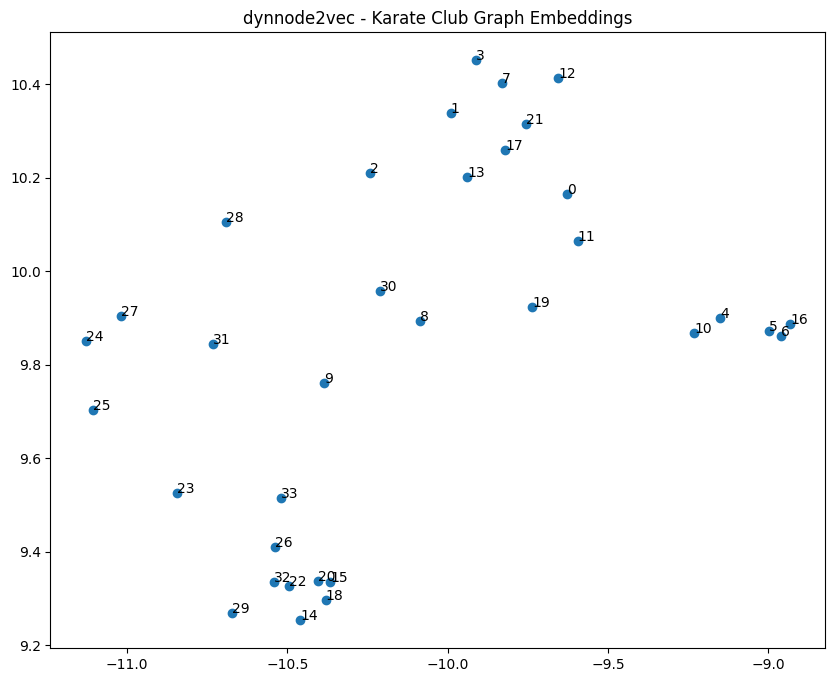

In [46]:
from __future__ import annotations

from collections import namedtuple
from typing import Any, Iterable

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

Embedding = namedtuple("Embedding", ["vectors", "mapping"])


class DynNode2Vec:
    def __init__(
        self,
        p: float = 1.0,
        q: float = 1.0,
        walk_length: int = 30,
        n_walks_per_node: int = 10,
        embedding_size: int = 128,
        window: int = 10,
        seed: int | None = 0,
        parallel_processes: int = 4,
        plain_node2vec: bool = False,
    ):
        self.p = p
        self.q = q
        self.walk_length = walk_length
        self.n_walks_per_node = n_walks_per_node
        self.embedding_size = embedding_size
        self.window = window
        self.seed = seed
        self.parallel_processes = parallel_processes
        self.plain_node2vec = plain_node2vec

    def _initialize_embeddings(self, graph: nx.Graph) -> tuple[Word2Vec, Embedding]:
        walks = self._generate_walks(graph)
        model = Word2Vec(
            sentences=walks,
            vector_size=self.embedding_size,
            window=self.window,
            min_count=0,
            sg=1,
            seed=self.seed,
            workers=max(self.parallel_processes - 1, 1),
        )
        embedding = Embedding(model.wv.vectors.copy(), model.wv.index_to_key.copy())
        return model, embedding

    def _generate_walks(self, graph: nx.Graph) -> list[list[Any]]:
        walks = []
        for node in graph.nodes():
            for _ in range(self.n_walks_per_node):
                walk = [node]
                while len(walk) < self.walk_length:
                    cur = walk[-1]
                    neighbors = list(graph.neighbors(cur))
                    if neighbors:
                        walk.append(np.random.choice(neighbors))
                    else:
                        break
                walks.append(walk)
        return walks

    def _update_embeddings(self, graph: nx.Graph, model: Word2Vec) -> Embedding:
        walks = self._generate_walks(graph)
        if self.plain_node2vec:
            model = Word2Vec(
                sentences=walks,
                vector_size=self.embedding_size,
                window=self.window,
                min_count=0,
                sg=1,
                seed=self.seed,
                workers=max(self.parallel_processes - 1, 1),
            )
        else:
            model.build_vocab(walks, update=True)
            model.train(walks, total_examples=model.corpus_count, epochs=model.epochs)
        embedding = Embedding(model.wv.vectors.copy(), model.wv.index_to_key.copy())
        return embedding

    def compute_embeddings(self, graphs: list[nx.Graph]) -> list[Embedding]:
        model, initial_embedding = self._initialize_embeddings(graphs[0])
        embeddings = [initial_embedding]
        for graph in graphs[1:]:
            embedding = self._update_embeddings(graph, model)
            embeddings.append(embedding)
        return embeddings


def visualize_embeddings(embeddings: list[Embedding], title: str = "Graph Embeddings"):
    last_embedding = embeddings[-1]
    tsne = TSNE(n_components=2, random_state=0)
    node_pos = tsne.fit_transform(last_embedding.vectors)
    plt.figure(figsize=(10, 8))
    plt.scatter(node_pos[:, 0], node_pos[:, 1])
    for i, label in enumerate(last_embedding.mapping):
        plt.annotate(label, (node_pos[i, 0], node_pos[i, 1]))
    plt.title(title)
    plt.show()


# Example usage with Karate Club graph
if __name__ == "__main__":
    # Create a dynamic graph list, here we use the same graph for simplicity
    graphs = [nx.karate_club_graph() for _ in range(3)]

    # Initialize and compute embeddings
    dyn_node2vec = DynNode2Vec()
    embeddings = dyn_node2vec.compute_embeddings(graphs)

    # Visualize embeddings
    visualize_embeddings(embeddings, title="dynnode2vec - Karate Club Graph Embeddings")


# Continuous-Time Dynamic Network Embeddings (CTDNE)

In [59]:
class Word2Vec:
    def __init__(self, size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.min_count = min_count
        self.sg = sg
        self.iter = iter
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.index2word = []
        self.word2index = {}
        self.syn0 = None
        self.syn1neg = None
        self.table = None
        self.table_size = int(1e8)

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1

        self.index2word = [word for word, count in self.vocab.items() if count >= self.min_count]
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Filtered vocabulary size: {len(self.index2word)}")

    def init_weights(self):
        vocab_size = len(self.index2word)
        self.syn0 = np.random.uniform(-0.5 / self.size, 0.5 / self.size, (vocab_size, self.size))
        self.syn1neg = np.zeros((vocab_size, self.size))

    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_weights()

        for i in tqdm(range(self.iter), desc="Training"):
            self.train_epoch(sentences)

    def train_epoch(self, sentences):
        for sentence in sentences:
            for i, word in enumerate(sentence):
                if word not in self.word2index:
                    continue
                word_idx = self.word2index[word]
                start = max(0, i - self.window)
                end = min(len(sentence), i + self.window + 1)
                for j in range(start, end):
                    if j != i:
                        context_word = sentence[j]
                        if context_word in self.word2index:
                            context_idx = self.word2index[context_word]
                            self.train_pair(word_idx, context_idx)

    def train_pair(self, word_idx, context_idx):
        l1 = self.syn0[word_idx]
        l2 = self.syn1neg[context_idx]

        product = np.dot(l1, l2)
        g = self.alpha * (1 - product)

        self.syn0[word_idx] += g * l2
        self.syn1neg[context_idx] += g * l1

    def get_embeddings(self):
        return {word: self.syn0[idx] for word, idx in self.word2index.items()}

In [76]:
import networkx as nx
import numpy as np
import pickle
import random

class TimeGraph:
    def __init__(self, graph, time_prop_name):
        self.G = graph
        self.time_prop_name = time_prop_name
        self.edges = list(self.G.edges(data=True))

        self.beta = None  # number of temporal context windows
        self.D = None  # embedding dimension 128
        self.L = None  # max walk length
        self.omega = None  # min walk length / context window size for skip gram

        self.all_time_walks = None
        self.num_nodes = len(list(self.G.nodes()))
        self.num_edges = len(self.edges)

    def set_temporal_walk_params(self, beta, D, omega, L=80):
        self.beta = beta
        self.D = D
        self.L = L
        self.omega = omega

    def sample_edge(self):
        num_edges = len(self.edges)
        choice = np.random.choice(num_edges)
        return self.edges[choice]

    def generate_ctdne_walks(self):  # Algorithm 1 from CTDNE paper
        # collection of random walks
        all_time_walks = []

        # initialize number of context windows
        C = 0
        counter = 0
        while self.beta - C > 0:
            u, v, prop = self.sample_edge()
            t = prop[self.time_prop_name]

            walk_t = self._temporal_walk(start_edge=(u, v), t=t, C=self.omega + self.beta - C - 1)
            if (walk_t is not None) and (len(walk_t) >= self.omega):
                all_time_walks.append(walk_t)
                C = C + (len(walk_t) - self.omega + 1)

            counter += 1
            if (counter + 1) % 1000 == 0:
                print('Loop ran for ', counter + 1, 'times!\t Current C = ', C)

        self.all_time_walks = all_time_walks

    def _temporal_walk(self, start_edge=None, t=None, C=0):  # Algorithm 2 from CTDNE
        """ Returns a random walk that respects time
            start: the start node of the random walk.
        """
        G = self.G
        prop_name = self.time_prop_name

        if start_edge:
            path = [start_edge[0], start_edge[1]]
        else:
            raise ValueError('start_edge should not be None.')

        curr_node = start_edge[1]

        for p in range(1, min(self.L, C)):
            # select next nodes whose time (curr_node, next_node) is greater than t
            neighbor_candidates = []
            for u, v, prop in G.edges(curr_node, data=True):
                if prop[prop_name] >= t:
                    neighbor_candidates.append((v, prop[prop_name]))

            # check if there are valid neighbors to walk to
            if len(neighbor_candidates) > 0:
                # set new current node & t
                idx_next_node = np.random.choice(range(len(neighbor_candidates)))
                curr_node, t = neighbor_candidates[idx_next_node]

                # add new current node to path
                path.append(curr_node)
            else:
                break
        return path



def main():
    graph = nx.karate_club_graph()
    # Assigning random time values for demonstration purposes
    for u, v in graph.edges():
        graph[u][v]['time'] = random.randint(0, 100)

    path = 'karate_club_walks.pkl'

    timeG = TimeGraph(graph, 'time')

    R = 80
    N = timeG.num_nodes
    omega = 10
    L = 80
    beta = R * N * (L - omega + 1)

    print("Beta value:", beta)

    print("Started Walk...")

    timeG.set_temporal_walk_params(beta=beta, D=128, omega=omega, L=L)
    timeG.generate_ctdne_walks()

    ctdne_walks = timeG.all_time_walks

    with open(path, 'wb') as f:
        pickle.dump(ctdne_walks, f)


if __name__ == '__main__':
    main()


Beta value: 193120
Started Walk...
Loop ran for  1000 times!	 Current C =  71928
Loop ran for  2000 times!	 Current C =  143928


In [79]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the embeddings
with open('karate_club_walks.pkl', 'rb') as f:
    ctdne_walks = pickle.load(f)

# Assuming each walk is a sequence of node IDs, concatenate all walks into a single list
all_nodes = [node for walk in ctdne_walks for node in walk]

# Generate unique node IDs
unique_nodes = list(set(all_nodes))

# Generate embeddings for each unique node ID (random embeddings for demonstration)
embeddings = {node_id: np.random.rand(128) for node_id in unique_nodes}

# Convert embeddings into a matrix
embedding_matrix = np.array([embeddings[node_id] for node_id in unique_nodes])
embedding_matrix


array([[0.42550304, 0.91104601, 0.04562955, ..., 0.88251895, 0.94592487,
        0.28716402],
       [0.56699009, 0.02094717, 0.22313935, ..., 0.78225128, 0.04924175,
        0.16001775],
       [0.07540185, 0.38572135, 0.77824983, ..., 0.23381591, 0.88680964,
        0.90495818],
       ...,
       [0.79378879, 0.92402623, 0.90592955, ..., 0.0180526 , 0.06495756,
        0.18911429],
       [0.46768908, 0.21228818, 0.60675703, ..., 0.28461713, 0.39457919,
        0.10418209],
       [0.5302951 , 0.78151788, 0.23501255, ..., 0.76314327, 0.93056799,
        0.58109995]])

Vocabulary size: 34
Filtered vocabulary size: 34


Training: 100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


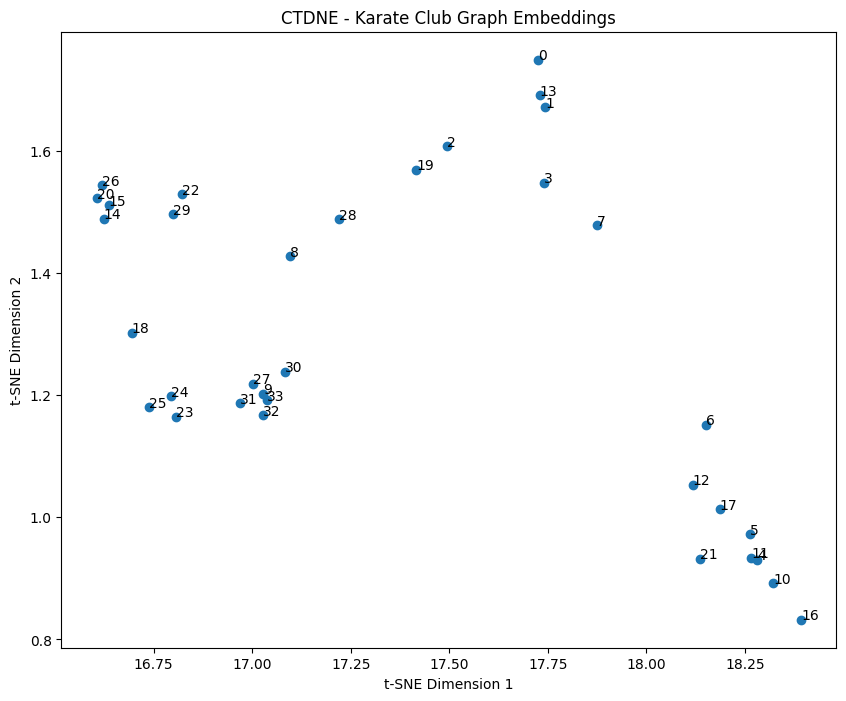

In [80]:
# Load karate club walks
with open("karate_club_walks.pkl", "rb") as f:
    karate_club_walks = pickle.load(f)

# Generate karate club graph
graph = nx.karate_club_graph()

# Train Word2Vec model
w2v_model = Word2Vec(size=128)
w2v_model.train(karate_club_walks)

# Get node embeddings
node_embeddings = w2v_model.get_embeddings()

# Convert embeddings to numpy array
node_embeddings_np = np.array(list(node_embeddings.values()))

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_tsne = tsne.fit_transform(node_embeddings_np)

# Visualize node embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_tsne[:, 0], node_embeddings_tsne[:, 1])
for i, txt in enumerate(node_embeddings.keys()):
    plt.annotate(txt, (node_embeddings_tsne[i, 0], node_embeddings_tsne[i, 1]))
plt.title('CTDNE - Karate Club Graph Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()